## Part 2: Parameter estimation in a state-space model

In this exercise, we shall develop models to predict the temperature evolution in a transformer station in a DSO (distribution system operator, distributing electricity from high-voltage grid out to the end consumer) grid. Transformer stations are vital to the electricity transportation system, and having the operate optimally is advantagous.
A brief introduction to a transformer station. Roughly speaking, a transformer station receives electricity at a high voltage and sends out electricity at a lower voltage. In this process, some energy is lost in the transformer and converted into heat. 

DSO transformer stations typically use oil for cooling (like water cooling, just with oil). 
The highest temperature inside the transformer station needs to be below a given threshold in order to limit the speed of degradation of the transformer station and to avoid it catching fire. In this data, a good approximation to this temperature is measured. We would now like a model that is able to predict this temperature.

### 2.1

In [2]:
import pandas as pd

df = pd.read_csv('./transformer_data.csv')
df.describe()

,time,Y,Ta,S,I
count,168.000000,168.000000,168.000000,168.000000,168.000000
mean,84.500000,27.650595,10.023115,214.432540,18.179092
std,48.641546,5.455816,2.916687,259.451647,3.662521
min,1.000000,19.828583,4.516667,0.000000,14.386027
25%,42.750000,23.246383,7.866667,0.000000,15.635851
50%,84.500000,26.066717,9.750000,65.416667,16.367102
75%,126.250000,32.201554,12.000000,410.250000,21.212430
max,168.000000,38.923850,17.466667,755.833333,25.362786


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

PARAMETERS = {"col":["Y", "Ta", "S", "I"], "z_col":["Y_z", "Ta_z", "S_z", "I_z"], "tex_col": ["Y_t", "T_{a, t}", "\Phi_{s,t}", "\Phi_{I,t}"], "col_unit":["◦C", "◦C", "W / m^2", "kA"], "col_name":["Transformer Station Temperature", "Outdoor Air Temperature", "Horizontal Global Solar Radiation", "Load on the Transformer Station"]}
for col in PARAMETERS["col"]:
    df[col+"_z"] = (df[col]-df[col].mean())/df[col].std()

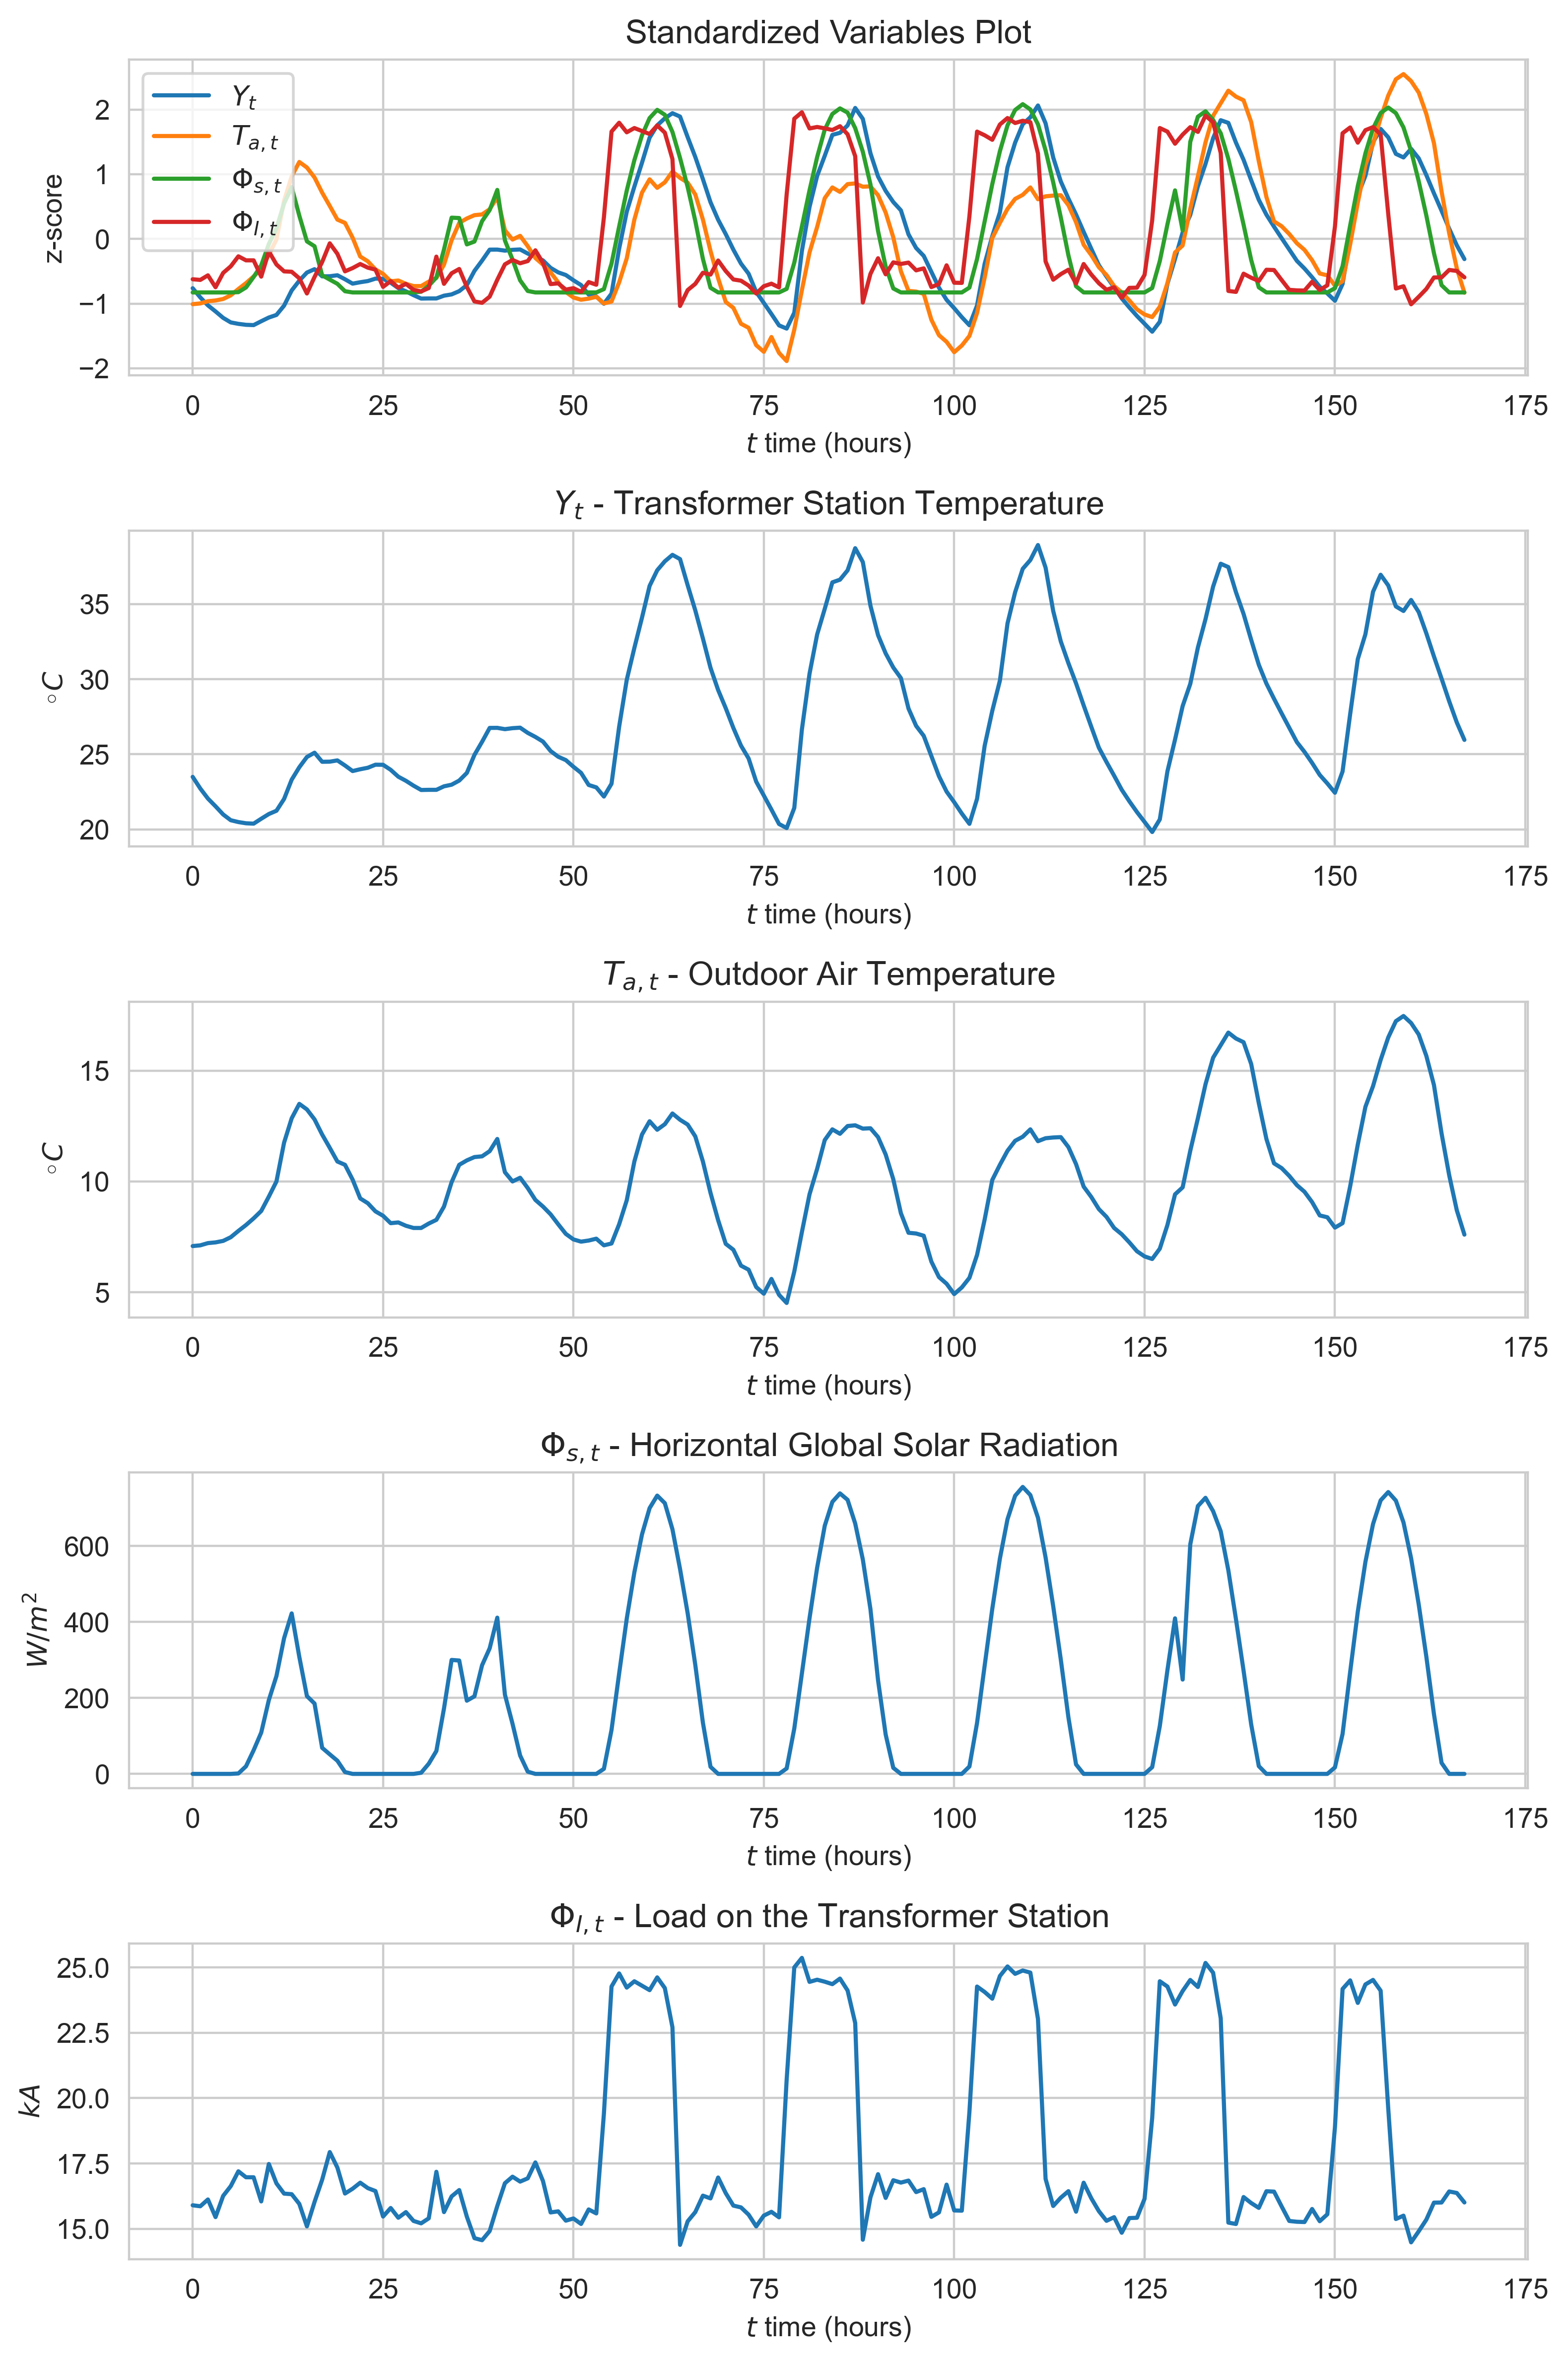

In [4]:
plt.figure(figsize=(8,12), dpi=400)

plt.subplot(5,1,1)
plt.title("Standardized Variables Plot")
for param, tex_param in zip(PARAMETERS["z_col"], PARAMETERS["tex_col"]):
    plt.plot(df[param], label=f"${tex_param}$")
plt.xlabel("$t$ time (hours)")
plt.ylabel("z-score")
plt.legend()

for i, param in enumerate(PARAMETERS["col"]):
    plt.subplot(5,1,i+2)
    plt.title(f'${PARAMETERS["tex_col"][i]}$ - {PARAMETERS["col_name"][i]}')
    plt.plot(df[param])
    plt.xlabel('$t$ time (hours)')
    plt.ylabel(f'${PARAMETERS["col_unit"][i]}$')

plt.tight_layout()

*Comment:*

There is very clearly a seasonality for day/night-cycles in all variables. 
The solar radiation $\Phi_{s,t}$ drops to $0$ during the night, which the load $\Phi_{I,t}$ mirrors almost exactly. It has a slightly quicker drop, once the sun is setting and during the peaks it displays a wiggle, which suggests some sort of load controller or a load maximum with excess being discharged. Lower peaks or crumples in the radiation curve could be explained by cloud cover.
A curious thing to notice, is that the load on the transformer $\Phi_{I,t}$ appears to have a quicker attack-time to rise, than the solar radiation $\Phi_{s,t}$. Intuitively, we would expect the solar radiation to lead and load to lag.
The $Y_t$ temperature follows $\Phi_{s,t}$ showing some cool-down period, once solar radiation dropped, hence a slower decay in temperature.
Outdoor temperature $T_{a,t}$ not only follows the solar radiation, hence daily 24h seasonality, but also exhibits a longer period seasonality, which could be climate and wheather effects.

Overall, we can actually deduce a lot from just outdoor temperature and solar radiation cycles, especially the uninterrupted (unclouded) ones.
When inspecting the graph, we can deduce about 17h of daylight, which excludes locations betwee $\approx \pm 54$ degrees N/S. In the southern-hemisphere there is only 'Tierra de Fuego' the southern cape of Latin America that is still land-mass, but it does not match the temperature profile (as even in summer, for the long daylight hours, it has max. temperatures of about 8 degrees Celsius). One could possible match the outdoor temperature with weather data to deduce a more accurate location.

### 2.2

In [5]:
import numpy as np
from scipy.optimize import minimize

def kalman_loglik_1d(par, df):
    a = par[0]
    B = par[1:4]
    c = par[4]
    sigma1 = np.exp(par[5])  # log-transform to ensure positivity
    sigma2 = np.exp(par[6])
    
    Y = df["Y"].values
    U = df[["Ta", "S", "I"]].values
    
    T = len(Y)
    x_pred = 20.0  # initial state guess
    P_pred = 10.0  # initial uncertainty
    
    loglik = 0.0
    for t in range(T):
        # Prediction
        x_pred = a * x_pred + np.dot(B, U[t])
        P_pred = a**2 * P_pred + sigma1**2
        
        # Update
        y_pred = c*x_pred
        S = P_pred + sigma2**2
        innov = Y[t] - y_pred
        loglik += -0.5 * (np.log(2*np.pi*S) + (innov**2)/S)
        
        # Kalman update
        K = P_pred / S
        x_pred = x_pred + K * innov
        P_pred = (1 - K) * P_pred
        
    return -loglik  # negative for minimization

def estimate_1d_state_space(df):
    start = np.array([0.9, 0.1, 0.1, 0.1, 0.1, np.log(1), np.log(1)])
    bounds = [(-1, 1), (-2, 2), (-2, 2), (-2, 2), (-2, 2), (np.log(1e-3), np.log(10)), (np.log(1e-3), np.log(10))]
    
    result = minimize(kalman_loglik_1d, start, args=(df,), bounds=bounds, method='L-BFGS-B')
    return result


In [6]:
estimate_1d_state_space(df)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 155.33958715809987
        x: [ 8.011e-01  7.922e-02  2.087e-03  1.558e-01  1.354e+00
            -5.024e-01 -6.908e+00]
      nit: 138
      jac: [-1.525e-02 -6.290e-03  1.048e-02 -1.449e-02 -1.907e-03
             2.188e-04  9.379e-05]
     nfev: 1368
     njev: 171
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

In [7]:
def simulate_ssm(A, B, C, D, Q, R, u, x0=None, seed=None):
    """
    Simulate a linear Gaussian state-space model.
    
    Parameters:
        A, B, C, D: system matrices
        Q, R: process and observation noise covariances
        u: exogenous input of shape (T, p)
        x0: initial state (n,), defaults to 0
        seed: random seed for reproducibility
        
    Returns:
        y: simulated observations (T, m)
        x: latent states (T+1, n)
    """
    rng = np.random.default_rng(seed)
    T, p = u.shape
    n = A.shape[0]
    m = C.shape[0]
    
    x = np.zeros((T+1, n))
    y = np.zeros((T, m))
    if x0 is not None:
        x[0] = x0

    for t in range(T):
        if Q.shape[0]:
            w_t = rng.normal(scale=Q)
        else:
            w_t = rng.multivariate_normal(np.zeros(n), Q)
        if R.shape[0]:
            v_t = rng.normal(scale=R)
        else:
            v_t = rng.multivariate_normal(np.zeros(m), R)
        x[t+1] = A @ x[t] + B @ u[t] + w_t
        y[t] = C @ x[t] + D @ u[t] + v_t

    return y, x


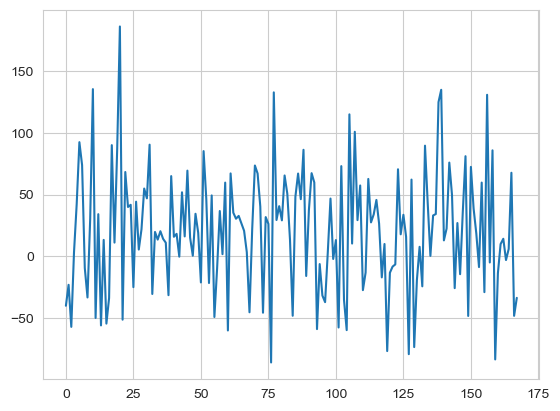

In [8]:
res = estimate_1d_state_space(df)
a = np.array([res.x[0]])
B = np.array(res.x[1:4]).reshape(1,-1)
c = np.array([res.x[4]])
q = np.array([res.x[5]**2])
r = np.array([res.x[6]**2])
u = df[["Ta", "S", "I"]].values

y, x = simulate_ssm(a, B, c, D=np.array([0, 0, 0]), Q=q, R=r, u=u)
plt.plot(y)

In [9]:
# w/o C

def kalman_loglik_1d(par, df):
    a = par[0]
    B = par[1:4]
    sigma1 = np.exp(par[4])  # log-transform to ensure positivity
    sigma2 = np.exp(par[5])
    
    Y = df["Y"].values
    U = df[["Ta", "S", "I"]].values
    
    T = len(Y)
    x_pred = 20.0  # initial state guess
    P_pred = 10.0  # initial uncertainty
    
    loglik = 0.0
    for t in range(T):
        # Prediction
        x_pred = a * x_pred + np.dot(B, U[t])
        P_pred = a**2 * P_pred + sigma1**2
        
        # Update
        y_pred = x_pred
        S = P_pred + sigma2**2
        innov = Y[t] - y_pred
        loglik += -0.5 * (np.log(2*np.pi*S) + (innov**2)/S)
        
        # Kalman update
        K = P_pred / S
        x_pred = x_pred + K * innov
        P_pred = (1 - K) * P_pred
        
    return -loglik  # negative for minimization

def estimate_1d_state_space(df):
    start = np.array([0.9, 0.1, 0.1, 0.1, np.log(1), np.log(1)])
    bounds = [(-1, 1), (-2, 2), (-2, 2), (-2, 2), (np.log(1e-3), np.log(10)), (np.log(1e-3), np.log(10))]
    
    result = minimize(kalman_loglik_1d, start, args=(df,), bounds=bounds, method='L-BFGS-B')
    return result


In [10]:
estimate_1d_state_space(df)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 166.31056558543523
        x: [ 8.011e-01  1.018e-01  2.871e-03  2.135e-01 -4.391e-01
            -6.908e+00]
      nit: 115
      jac: [-1.747e-01 -4.111e-02 -5.149e-01 -1.380e-01  1.933e-03
             2.075e-04]
     nfev: 903
     njev: 129
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

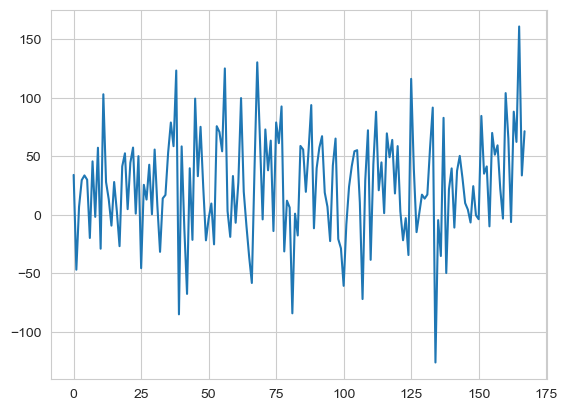

In [11]:
res = estimate_1d_state_space(df)
a = np.array([res.x[0]])
B = np.array(res.x[1:4]).reshape(1,-1)
q = np.array([res.x[4]**2])
r = np.array([res.x[5]**2])
u = df[["Ta", "S", "I"]].values

y, x = simulate_ssm(a, B, C=np.array([1]), D=np.array([0, 0, 0]), Q=q, R=r, u=u)
plt.plot(y)

In [12]:
def kalman_loglik_1d_fixed(par, df):
    a = par[0]
    B = np.array(par[1:4])
    c = par[4]  # include C!
    sigma1 = np.exp(par[5])  # enforce positivity
    sigma2 = np.exp(par[6])

    Y = df["Y"].values
    U = df[["Ta", "S", "I"]].values

    T = len(Y)
    x_pred = 20.0
    P_pred = 10.0

    loglik = 0.0
    for t in range(T):
        # Prediction step
        x_pred = a * x_pred + np.dot(B, U[t])
        P_pred = a**2 * P_pred + sigma1**2

        # Observation prediction
        y_pred = c * x_pred
        S = c**2 * P_pred + sigma2**2
        innov = Y[t] - y_pred

        # Log-likelihood
        loglik += -0.5 * (np.log(2 * np.pi * S) + (innov**2) / S)

        # Kalman gain
        K = P_pred * c / S
        x_pred = x_pred + K * innov
        P_pred = (1 - K * c) * P_pred

    return -loglik


def estimate_1d_state_space_fixed(df):
    # start = [a, B1, B2, B3, c, log(sigma1), log(sigma2)]
    start = np.array([0.8, 0.05, 0.1, 0.1, 1.0, np.log(2), np.log(2)])
    bounds = [(-2, 2), (-5, 5), (-5, 5), (-5, 5), (0.5, 1.5),  # c ~ 1
              (1e-3, np.log(10)), (1e-3, np.log(10))]

    result = minimize(kalman_loglik_1d_fixed, start, args=(df,), bounds=bounds, method='L-BFGS-B')
    return result


In [13]:
estimate_1d_state_space_fixed(df)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 240.57565718508923
        x: [ 7.961e-01  1.441e-01  3.819e-03  2.971e-01  7.389e-01
             1.000e-03  1.000e-03]
      nit: 60
      jac: [ 2.213e-02  6.037e-03  1.119e-01  1.434e-02  8.464e-03
             2.606e+01  8.063e+01]
     nfev: 600
     njev: 75
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

For some reason, sigma1 and sigma2 are driven to the lower boundry of the optimizer. Is the system thus just noise free?

In [14]:
def simulate_from_model(par, df):
    a = par[0]
    B = np.array(par[1:4])
    c = par[4]
    sigma1 = np.exp(par[5])
    sigma2 = np.exp(par[6])

    U = df[["Ta", "S", "I"]].values
    T = len(U)
    X = np.zeros(T + 1)
    Y = np.zeros(T)
    X[0] = 20.0  # initial condition

    for t in range(T):
        X[t+1] = a * X[t] + np.dot(B, U[t]) + np.random.normal(0, sigma1)
        Y[t] = c * X[t+1] + np.random.normal(0, sigma2)

    return Y, X[1:]


In [15]:
res = estimate_1d_state_space_fixed(df)
y, x = simulate_from_model(res.x, df)

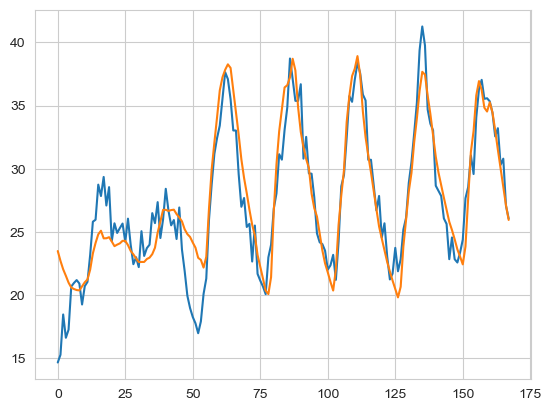

In [16]:
plt.plot(y)
plt.plot(df["Y"])

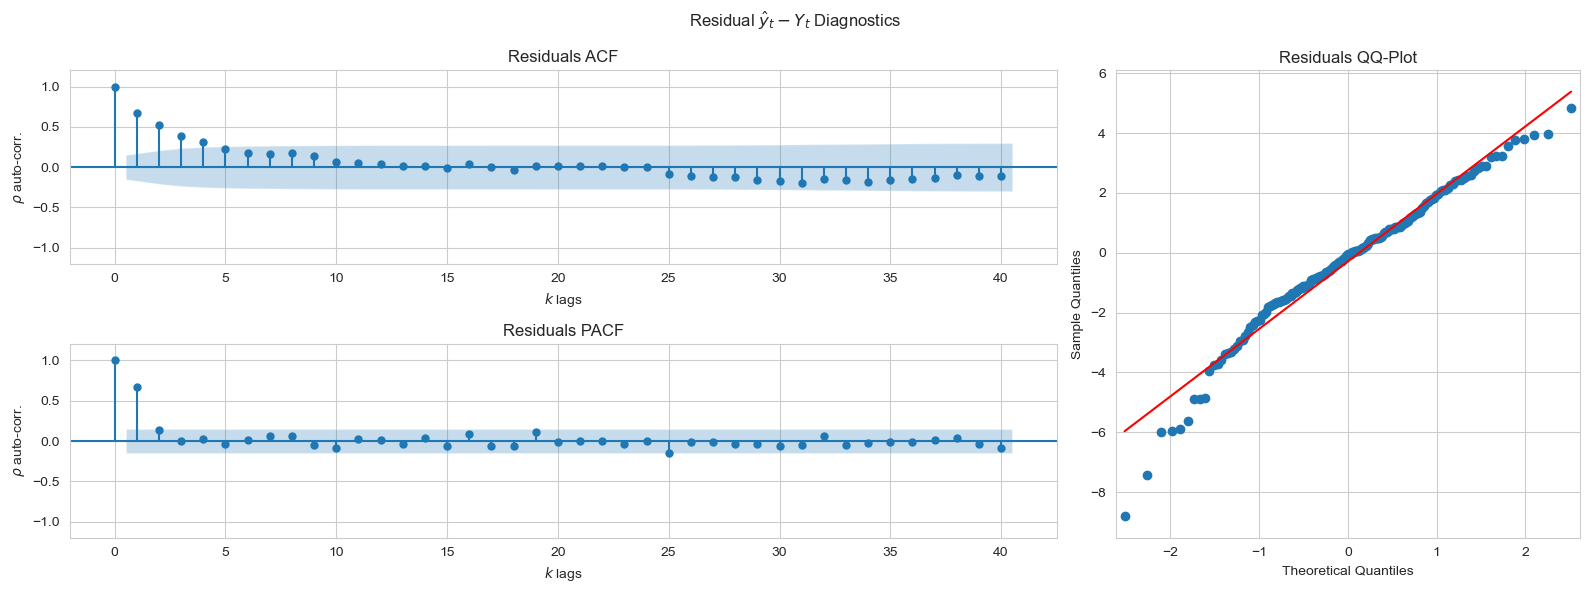

In [17]:
from project.utils import plot_residual_diagnostics

residuals = y - df["Y"]
plot_residual_diagnostics(residuals)

### 2.3

**2-dim state-space model:**

$$
\mathbf{X}_{t+1} = \mathbf{A} \mathbf{X}_t + \mathbf{B} \mathbf{u}_t + \mathbf{e}_{1,t} \\
Y_t = \mathbf{C} \mathbf{X}_t + e_{2,t}
$$

* $\mathbf{X}_t \in \mathbb{R}^2$, $\mathbf{u}_t \in \mathbb{R}^3$
* $\mathbf{A} \in \mathbb{R}^{2\times2}, \mathbf{B} \in \mathbb{R}^{2\times3}, \mathbf{C} \in \mathbb{R}^{1\times2}$

In [ ]:
 def kalman_loglik_2d(par, df):
    A = par[0:4].reshape(2, 2)
    B = par[4:10].reshape(2, 3)
    C = par[10:12].reshape(1, 2)
    sigma1 = np.exp(par[12])  # system noise (shared scalar for simplicity)
    sigma2 = np.exp(par[13])  # observation noise
    
    Y = df["Y"].values
    U = df[["Ta", "S", "I"]].values
    T = len(Y)
    
    x_pred = np.array([20.0, 20.0])
    P_pred = np.eye(2) * 10.0
    
    loglik = 0.0
    for t in range(T):
        x_pred = A @ x_pred + B @ U[t]
        P_pred = A @ P_pred @ A.T + np.eye(2) * sigma1**2
        
        y_pred = C @ x_pred
        S = C @ P_pred @ C.T + sigma2**2
        innov = Y[t] - y_pred
        loglik += -0.5 * (np.log(2*np.pi*S) + (innov**2)/S)
        
        K = P_pred @ C.T / S
        x_pred = x_pred + K.flatten() * innov
        P_pred = P_pred - K @ C @ P_pred
        
    return -loglik

def estimate_2d_state_space(df):
    start = np.array([0.8, 0.1, 0.0, 0.7,   # A
                      0.1, 0.1, 0.1,        # B row 1
                      0.0, 0.0, 0.0,        # B row 2
                      1.0, 0.2,             # C
                      0, 0])                # log sigma1, sigma2
    bounds = [(-2, 2)] * (len(start)-2) + [(0,2)] * 2
    result = minimize(kalman_loglik_2d, start, args=(df,), bounds=bounds, method='L-BFGS-B')
    return result


In [27]:
res = estimate_2d_state_space(df)
res

  message: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 228.05917324113474
        x: [ 1.656e+00  2.000e+00 ...  0.000e+00  0.000e+00]
      nit: 782
      jac: [ 2.586e+00 -2.028e+00 ...  1.973e+01  9.406e+01]
     nfev: 15015
     njev: 1001
 hess_inv: <14x14 LbfgsInvHessProduct with dtype=float64>

In [40]:
def simulate_from_model_2d(par, df):
    A = par[0:4].reshape(2,2)
    B = np.array(par[4:10]).reshape(2,3)
    C = par[10:12].reshape(1,2)
    sigma1 = np.exp(par[12])
    sigma2 = np.exp(par[13])

    U = df[["Ta", "S", "I"]].values
    T = len(U)
    X = np.zeros((T + 1, 2))
    Y = np.zeros(T)
    X[0] = 20.0  # initial condition

    for t in range(T):
        X[t+1] = A@X[t] + np.dot(B, U[t]) + np.random.multivariate_normal(mean=np.array([0,0]).reshape(-1,), cov=np.eye(2)*sigma1)
        Y[t] = C@X[t+1] + np.random.normal(0, sigma2)

    return Y, X[1:]

y, x = simulate_from_model_2d(res.x, df)

/var/folders/5b/3rjqcwwn5s93khgglxljhv140000gn/T/ipykernel_68247/4099211446.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[t] = C@X[t+1] + np.random.normal(0, sigma2)


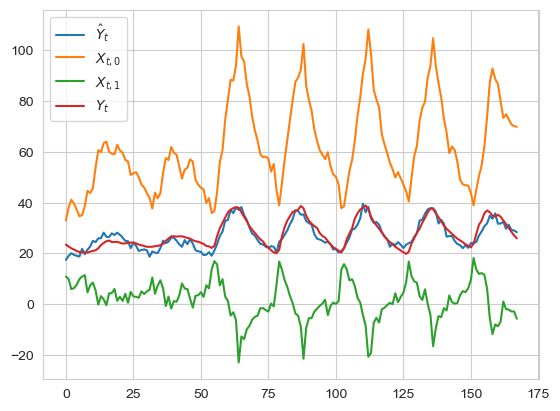

In [47]:
plt.plot(y, label="$\hat{Y}_t$")
plt.plot(x[:,0], label="$X_{t,0}$")
plt.plot(x[:,1], label="$X_{t,1}$")
plt.plot(df["Y"], label="$Y_t$")
plt.legend()

### 2.4

In [ ]:
def reconstruct_states(par, df):
    A = par[0:4].reshape(2, 2)
    B = par[4:10].reshape(2, 3)
    C = par[10:12].reshape(1, 2)
    sigma1 = np.exp(par[12])
    sigma2 = np.exp(par[13])
    
    Y = df["Y"].values
    U = df[["Ta", "S", "I"]].values
    T = len(Y)
    
    x_pred = np.array([20.0, 20.0])
    P_pred = np.eye(2) * 10.0
    
    states = []
    for t in range(T):
        x_pred = A @ x_pred + B @ U[t]
        P_pred = A @ P_pred @ A.T + np.eye(2) * sigma1**2
        
        y_pred = C @ x_pred
        S = C @ P_pred @ C.T + sigma2**2
        innov = Y[t] - y_pred
        
        K = P_pred @ C.T / S
        x_pred = x_pred + K.flatten() * innov
        P_pred = P_pred - K @ C @ P_pred
        states.append(x_pred.copy())
        
    return np.array(states)

# use the previous optimized starting values
x = reconstruct_states(res.x, df)
plt.plot(x)

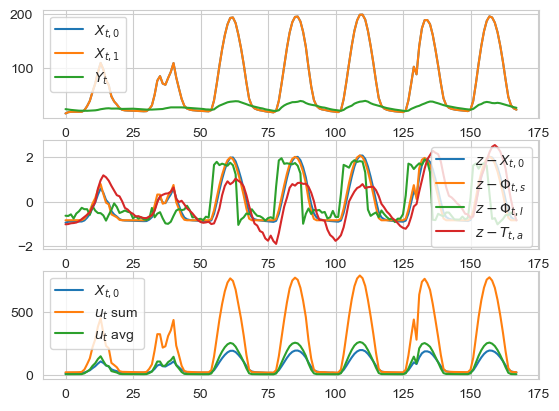

In [65]:
# reconstruct without likelihood
x = reconstruct_states(np.ones(14), df)

# plot hidden states X_t against exogenous variables

plt.subplot(3,1,1)
plt.plot(x[:,0], label="$X_{t,0}$")
plt.plot(x[:,1], label="$X_{t,1}$")
plt.plot(df["Y"], label="$Y_t$")
plt.legend()

plt.subplot(3,1,2)
plt.plot((x[:,0]-np.mean(x[:,0]))/np.std(x[:,0]), label="$z-X_{t,0}$")
plt.plot((df["S"]-df["S"].mean())/df["S"].std(), label="$z-\Phi_{t,s}$")
plt.plot((df["I"]-df["I"].mean())/df["I"].std(), label="$z-\Phi_{t,I}$")
plt.plot((df["Ta"]-df["Ta"].mean())/df["Ta"].std(), label="$z-T_{t,a}$")
plt.legend()

plt.subplot(3,1,3)
plt.plot(x[:,0], label="$X_{t,0}$")
plt.plot(df["S"]+df["I"]+df["Ta"], label="$u_t$ sum")
plt.plot((df["S"]+df["I"]+df["Ta"])/3, label="$u_t$ avg")
plt.legend()

*Conclusion:*

- no optimization and 1-initialized leads to avg of exogenous $u_t$ as state vectors $X_t$ (+/- a little noise)
- of course with correct parameter values A, B, C, D, sigma1, sigma2 initialized, it becomes an accurate reconstruction

**Interpretation Guidance:**

* Plot $X_{1,t}$, $X_{2,t}$ vs. time and against inputs $Ta_t, \Phi_{s,t}, \Phi_{I,t}$
* Analyze:

  * Does one state correlate with load?
  * Does one act as a lagging “thermal buffer”?
* Check sign/magnitude of **B** matrix to infer effect of each input


_________

In [180]:
def kalman_loglik(Y:np.ndarray, A:np.ndarray=A, B:np.ndarray=B, C:np.ndarray=C, D:np.ndarray=D, Q:np.ndarray=Q, R:np.ndarray=R, u_df:pd.DataFrame=None, x0:int=20):
    U = u_df[["Ta", "S", "I"]].values
    T = len(Y)
    n = A.shape[0]

    # initialization
    x_pred = np.ones(n)*x0
    P_pred = np.eye(n)*20.0

    loglik = 0.0
    for t in range(T):

        # Prediction step
        x_pred = A @ x_pred + B @ U[t]
        P_pred = A @ P_pred @ A.T + Q**2

        # Observation prediction with D @ u_t
        y_pred = (C @ x_pred + D @ U[t]).item()
        S = (C @ P_pred @ C.T).item() + R**2
        innov = Y[t] - y_pred

        # Log-likelihood
        loglik += -0.5 * (np.log(2 * np.pi * S) + (innov**2) / S)

        # Kalman update
        K = (P_pred @ C.T) / S
        x_pred = x_pred + (K.flatten() * innov)
        P_pred = P_pred - K @ C @ P_pred

    return float(-loglik[0][0])


In [181]:
def flatten_params(A, B, C, D, Q, R, x0):
    return np.concatenate([
        A.flatten(),
        B.flatten(),
        C.flatten(),
        D.flatten(),
        Q.flatten(),
        np.atleast_1d(R).flatten(),
        x0.flatten()
    ])

def unpack_params(param_vector, shapes):
    A_shape, B_shape, C_shape, D_shape, Q_shape, R_shape, x0_shape = shapes
    idx = 0

    def next_block(shape):
        nonlocal idx
        size = np.prod(shape)
        block = param_vector[idx:idx + size].reshape(shape)
        idx += size
        return block

    A = next_block(A_shape)
    B = next_block(B_shape)
    C = next_block(C_shape)
    D = next_block(D_shape)
    Q = next_block(Q_shape)
    R = next_block(R_shape)
    x0 = next_block(x0_shape)
    return A, B, C, D, Q, R, x0

def estimate_ssm_parameters(kalman_loglik, Y, u_df,
                            A_shape, B_shape, C_shape, D_shape, Q_shape, R_shape, x0_shape,
                            start, bounds, max_retries=3, tol=1e-6):
    shapes = (A_shape, B_shape, C_shape, D_shape, Q_shape, R_shape, x0_shape)

    def wrapped_loglik(param_vec):
        A, B, C, D, Q, R, x0 = unpack_params(param_vec, shapes)
        return kalman_loglik(Y=Y, A=A, B=B, C=C, D=D, Q=Q, R=R, u_df=u_df, x0=x0)

    attempt = 0
    current_start = start.copy()

    while attempt < max_retries:
        result = minimize(
            fun=wrapped_loglik,
            x0=current_start,
            bounds=bounds,
            method='L-BFGS-B',
            options={"disp": True, "maxiter": 1000}
        )

        if result.success or result.fun < tol:
            break
        else:
            print(f"Retry {attempt + 1} failed, retrying...")
            current_start = result.x
            attempt += 1

    A, B, C, D, Q, R, x0 = unpack_params(result.x, shapes)
    return result, (A, B, C, D, Q, R, x0)


In [182]:
# example for 2.3
A_shape = (2, 2)
B_shape = (2, 3)
C_shape = (1, 2)
D_shape = (1, 3)
Q_shape = (2, 2)
R_shape = (1, 1)
x0_shape = (2,)

start_matrices = (
    np.eye(2),                  # A - 4
    np.random.rand(2, 3) * 0.1, # B - 6
    np.ones((1, 2)),            # C - 2
    np.zeros((1, 3)),           # D - 3
    np.eye(2) * 0.5,            # Q - 4
    np.array([[1.0]]),          # R - 1
    np.array([20.0, 20.0])      # x0 - 2
)

start_flat = flatten_params(*start_matrices)
bounds = [(-2, 2)] * 12 + [(0, 0)] * 3 + [(0,2)] * 5 + [(-50,50)] * 2 # adjust bounds as needed

# Then estimate:
result, (A_est, B_est, C_est, D_est, Q_est, R_est, x0_est) = estimate_ssm_parameters(
    kalman_loglik=kalman_loglik,
    Y=df["Y"].values,
    u_df=df[["Ta", "S", "I"]],
    A_shape=A_shape, B_shape=B_shape, C_shape=C_shape, D_shape=D_shape,
    Q_shape=Q_shape, R_shape=R_shape, x0_shape=x0_shape,
    start=start_flat,
    bounds=bounds
)


In [184]:
def simulate_ssm(A:np.ndarray=A, B:np.ndarray=B, C:np.ndarray=C, D:np.ndarray=D, Q:np.ndarray=Q, R:np.ndarray=R, u:np.ndarray=u, x0=None, seed:int=42):
    """
    Simulate a linear Gaussian state-space model.
    
    Parameters:
        A, B, C, D: system matrices
        Q, R: process and observation noise covariances
        u: exogenous input of shape (T, p)
        x0: initial state (n,), defaults to 0
        seed: random seed for reproducibility
        
    Returns:
        y: simulated observations (T, m)
        x: latent states (T+1, n)
    """
    rng = np.random.default_rng(seed)
    T, p = u.shape
    n = A.shape[0]
    m = C.shape[0]
    
    x = np.zeros((T+1, n))
    y = np.zeros((T, m))
    x[0] = np.ones(n)
    if x0 is not None:
        x[0] = x0

    for t in range(T):
        w_t = rng.multivariate_normal(np.zeros(n), Q)
        v_t = rng.multivariate_normal(np.zeros(m), R)
        x[t+1] = A @ x[t] + B @ u[t] + w_t
        y[t] = C @ x[t+1] + D @ u[t] + v_t

    return y, x


In [185]:
y, x = simulate_ssm(A_est, B_est, C_est, D_est, Q_est, R_est, df[["Ta", "S", "I"]].values, x0_est)

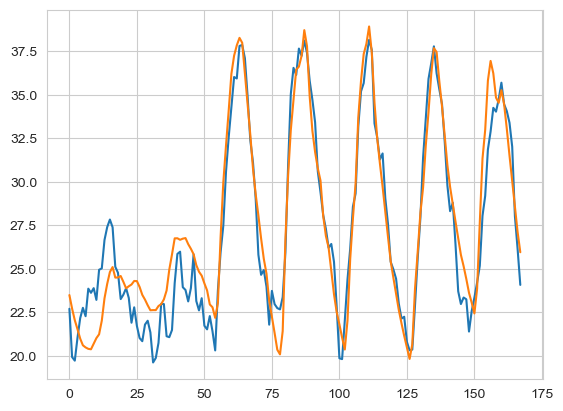

In [186]:
plt.plot(y)
plt.plot(df["Y"])